# 11 - Score de Propension

## La Psychologie de la Croissance

Le domaine de la psychologie positive étudie les comportements humains qui mènent à une vie épanouie. Vous pouvez la considérer comme l'intersection entre les livres de développement personnel et la rigueur académique des statistiques. L'une des découvertes célèbres de la psychologie positive est le **Mindset de Croissance**. L'idée est que les gens peuvent avoir un état d'esprit fixe ou un état d'esprit de croissance. Si vous avez un état d'esprit fixe, vous croyez que les capacités sont données à la naissance ou dans la petite enfance. Ainsi, l'intelligence est fixe et ne peut pas changer tout au long de la vie. Si vous ne l'avez pas déjà, vous ne pourrez pas l'acquérir. Le corollaire de cette pensée est que vous ne devriez pas perdre de temps sur des domaines où vous n'excellez pas, car vous n'apprendrez jamais à les maîtriser. D'autre part, si vous avez un état d'esprit de croissance, vous croyez que l'intelligence peut être développée. La conséquence directe de cela est que vous voyez l'échec non pas comme un manque de ténacité, mais comme une partie d'un processus d'apprentissage.

Je ne souhaite pas débattre sur lequel de ces états d'esprit est le bon (bien que la vérité se situe probablement quelque part au milieu). Pour notre propos, cela n'a pas trop d'importance. Ce qui compte, c'est que les psychologues ont découvert que les personnes ayant un état d'esprit de croissance ont tendance à mieux réussir dans la vie. Elles sont plus susceptibles d'atteindre les objectifs qu'elles se sont fixés.

Aussi expérimentés que nous le sommes en inférence causale, nous avons appris à aborder ces affirmations avec scepticisme. Est-ce qu'un état d'esprit de croissance pousse réellement les gens à accomplir davantage ? Ou est-ce simplement le cas que les personnes qui réussissent davantage sont enclines à développer un état d'esprit de croissance en raison de leur succès ? Qui est venu en premier, l'œuf ou la poule ? Dans la notation des résultats potentiels, nous avons des raisons de croire qu'il existe un biais dans ces affirmations. $Y_0|T=1$ est probablement plus grand que $Y_0|T=0$, ce qui signifie que ceux ayant un état d'esprit de croissance auraient réussi davantage même s'ils avaient un état d'esprit fixe.

Pour trancher la question, les chercheurs ont conçu la [National Study of Learning Mindsets](https://mindsetscholarsnetwork.org/about-the-network/current-initatives/national-mindset-study/#). Il s'agit d'une étude randomisée menée dans des lycées publics aux États-Unis qui vise à trouver l'impact d'un état d'esprit de croissance. Le fonctionnement est le suivant : les élèves reçoivent de l'école un séminaire pour leur inculquer un état d'esprit de croissance. Ensuite, ils suivent ces élèves pendant leurs années de collège pour mesurer leurs performances académiques. Cette mesure a été compilée dans un score de réussite et standardisée. Les données réelles de cette étude ne sont pas publiquement disponibles afin de préserver la confidentialité des élèves. Cependant, nous disposons d'un ensemble de données simulées avec les mêmes propriétés statistiques fourni par [Athey et Wager](https://arxiv.org/pdf/1902.07409.pdf), donc nous l'utiliserons à la place.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from causalinference import CausalModel

import graphviz as gr

%matplotlib inline

style.use("fivethirtyeight")
pd.set_option("display.max_columns", 6)

En plus des variables de traitement et de résultat, l'étude a également enregistré d'autres caractéristiques :

* schoolid : identifiant de l'école de l'élève ;
* success_expect : attentes de réussite auto-déclarées pour l'avenir, un indicateur de la réussite antérieure, mesuré avant l'affectation aléatoire ;
* ethnicity : variable catégorielle pour la race/ethnicité de l'élève ;
* gender : variable catégorielle pour le genre identifié de l'élève ;
* frst_in_family : variable catégorielle pour le statut de première génération de l'élève, c'est-à-dire le premier dans la famille à aller à l'université ;
* school_urbanicity : variable catégorielle au niveau de l'école pour l'urbanicité de l'école, c'est-à-dire rural, suburbain, etc. ;
* school_mindset : moyenne au niveau de l'école des mentalités fixes des élèves, rapportée avant l'affectation aléatoire, standardisée ;
* school_achievement : niveau de réussite de l'école, mesuré par les scores aux tests et la préparation à l'université des quatre cohortes précédentes d'élèves, standardisé ;
* school_ethnic_minority : composition raciale/ethnique minoritaire de l'école, c'est-à-dire pourcentage de la population étudiante qui est noire, latino ou amérindienne, standardisé ;
* school_poverty : concentration de la pauvreté dans l'école, c'est-à-dire pourcentage d'élèves issus de familles dont les revenus sont inférieurs au seuil de pauvreté fédéral, standardisé ;
* school_size : nombre total d'élèves dans les quatre niveaux de classe de l'école, standardisé.

In [2]:
data = pd.read_csv("./data/learning_mindset.csv")
data.sample(5, random_state=5)

,schoolid,intervention,achievement_score,...,school_ethnic_minority,school_poverty,school_size
259,73,1,1.480828,...,-0.515202,-0.169849,0.173954
3435,76,0,-0.987277,...,-1.310927,0.224077,-0.426757
9963,4,0,-0.152340,...,0.875012,-0.724801,0.761781
4488,67,0,0.358336,...,0.315755,0.054586,1.862187
2637,16,1,1.360920,...,-0.033161,-0.982274,1.591641


Bien que l'étude ait été randomisée, il ne semble pas que ces données soient exemptes de facteurs de confusion. Si nous examinons les caractéristiques supplémentaires, nous remarquerons qu'elles varient systématiquement entre le groupe de traitement et le groupe de contrôle. Une des raisons possibles à cela est que la variable de traitement est mesurée par la participation de l'élève au séminaire. Ainsi, bien que l'opportunité de participer ait été aléatoire, la participation elle-même ne l'est pas. Nous sommes ici confrontés à un cas de non-conformité. Une preuve de cela est que les attentes de réussite de l'élève sont corrélées avec la participation au séminaire. Les élèves ayant des attentes de réussite auto-déclarées plus élevées sont plus susceptibles d'avoir rejoint le séminaire sur le mindset de croissance.

In [3]:
data.groupby("success_expect")["intervention"].mean()

success_expect
1    0.271739
2    0.265957
3    0.294118
4    0.271617
5    0.311070
6    0.354287
7    0.362319
Name: intervention, dtype: float64

Voyons tout de même à quoi ressemble la différence de moyennes $E[Y|T=1] - E[Y|T=0]$. Cela constituera une référence utile pour effectuer des comparaisons par la suite.

In [4]:
smf.ols("achievement_score ~ intervention", data=data).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.1538,0.012,-13.201,0.000,-0.177,-0.131
intervention,0.4723,0.020,23.133,0.000,0.432,0.512


En comparant simplement ceux qui ont bénéficié de l'intervention à ceux qui ne l'ont pas reçue, nous pouvons voir que le groupe traité a un score de réussite qui est, en moyenne, 0,3185 (0,4723 - 0,1538) supérieur au score moyen (qui est de zéro, puisque le score est standardisé). Mais est-ce un écart important ou non ? Je sais que l'interprétation des résultats standardisés peut être complexe, mais tenez bon un instant. Je pense qu'il est utile de passer en revue cela, car ce ne sera pas la dernière fois que vous rencontrerez des scores standardisés.

Le fait que la variable de résultat soit standardisée signifie qu'elle est mesurée en écarts-types. Donc, les individus traités sont 0,3185 écarts-types au-dessus des non-traités. C'est ce que cela signifie. Quant à savoir si c'est petit ou grand, rappelons-nous quelques éléments sur la distribution normale. Nous savons que 95 % de sa masse se trouve entre 2 écarts-types, laissant 2,5 % dans une queue et 2,5 % dans l'autre. Cela signifie également que si quelqu'un se trouve à 2 écarts-types au-dessus de la moyenne, 97,5 % (95 % plus les 2,5 % de la queue gauche) de tous les individus se trouvent en dessous de cette personne. En regardant la fonction de répartition cumulée de la normale (CDF), nous savons également qu'environ 85 % de sa masse se trouve en dessous d'un écart-type et que 70 % de sa masse se trouve en dessous de 0,5 écart-type. Comme le groupe traité a un score moyen standardisé d'environ 0,5, cela signifie qu'ils se situent au-dessus de 70 % en termes de réussite individuelle. En d'autres termes, ils font partie des 30 % supérieurs en termes de réussite. Voici à quoi cela ressemble sous forme de graphique.

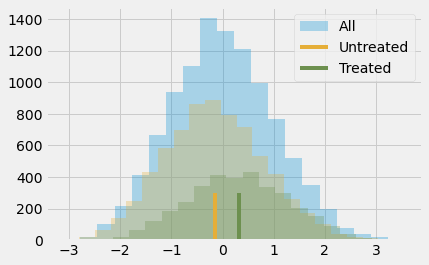

In [5]:
plt.hist(data["achievement_score"], bins=20, alpha=0.3, label="All")
plt.hist(data.query("intervention==0")["achievement_score"], bins=20, alpha=0.3, color="C2")
plt.hist(data.query("intervention==1")["achievement_score"], bins=20, alpha=0.3, color="C3")
plt.vlines(-0.1538, 0, 300, label="Untreated", color="C2")
plt.vlines(-0.1538+0.4723, 0, 300, label="Treated", color="C3")
plt.legend();

Bien sûr, nous pensons toujours que ce résultat est biaisé. La différence entre les traités et les non-traités est probablement plus petite que cela, car nous pensons que le biais est positif. Nous avons déjà vu que les personnes plus ambitieuses sont plus enclines à participer au séminaire, elles auraient donc probablement obtenu de meilleurs résultats même si elles n'y avaient pas assisté. Pour contrôler ce biais, nous pourrions utiliser la régression ou l'appariement, mais il est temps d'apprendre une nouvelle technique.

## Score de Propension

Le score de propension découle de la constatation que vous n'avez pas besoin de contrôler directement les variables confondantes X pour atteindre l'indépendance conditionnelle $(Y_1, Y_0) \perp T | X$. Il suffit de contrôler un score d'équilibrage $E[T|X]$. Ce score d'équilibrage est souvent la probabilité conditionnelle du traitement, $P(T|X)$, également appelée score de propension $e(x)$. Le score de propension permet de ne pas avoir à conditionner sur l'ensemble de X pour obtenir l'indépendance des résultats potentiels par rapport au traitement. Il suffit de conditionner sur cette seule variable, qui est le score de propension :

$
(Y_1, Y_0) \perp T | e(x)
$

Il existe une preuve formelle pour expliquer pourquoi cela fonctionne, mais nous pouvons l'oublier pour l'instant et aborder la question de manière plus intuitive. Le score de propension est la probabilité conditionnelle de recevoir le traitement, n'est-ce pas ? Nous pouvons donc le considérer comme une sorte de fonction qui convertit X en traitement T. Le score de propension établit un lien intermédiaire entre la variable X et le traitement T. Si nous devions représenter cela dans un graphique causal, voici à quoi cela ressemblerait.

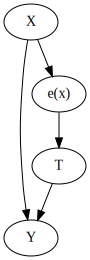

In [6]:
g = gr.Digraph()
g.edge("T", "Y")
g.edge("X", "Y")
g.edge("X", "e(x)")
g.edge("e(x)", "T")
g

Si je connais $e(x)$, X seul ne me donne aucune information supplémentaire qui pourrait m'aider à déterminer ce que serait T. Cela signifie que contrôler $e(x)$ revient à contrôler directement X. Pensez-y en termes de notre programme de mindset. Les traités et les non-traités ne sont pas comparables initialement, car les personnes plus ambitieuses sont à la fois plus susceptibles de suivre le traitement et de réussir davantage dans la vie. Cependant, si je prends deux individus, l'un traité et l'autre dans le groupe de contrôle, mais avec la même probabilité de recevoir le traitement, ils deviennent comparables. Réfléchissez-y. S'ils ont exactement la même probabilité de recevoir le traitement, la seule raison pour laquelle l'un d'eux l'a reçu et l'autre non est le pur hasard. En maintenant constant le score de propension, on agit de manière à rendre les données aussi proches que possible d'une distribution aléatoire.

Maintenant que nous avons compris l'intuition, examinons la preuve mathématique. Nous voulons montrer que $(Y_1, Y_0) \perp T | e(x)$ est équivalent à dire que 

$$
E[T|e(x), X] = E[T|e(x)] 
$$

Cela signifie simplement que, une fois que je conditionne sur $e(x)$, X ne peut plus me fournir d'informations supplémentaires sur $T$. La preuve de cela est assez étrange. Nous allons montrer que l'équation ci-dessus est vraie en la convertissant en une affirmation triviale. Regardons d'abord le côté gauche $E[T|e(x), X]$.

$$
E[T|e(x), X] = E[T|X] = e(x)
$$

Nous utilisons le fait que $e(x)$ n'est qu'une fonction de X, donc conditionner dessus ne donne aucune information supplémentaire après avoir conditionné sur X lui-même. Ensuite, nous utilisons la définition du score de propension $E[T|X]$. 

Pour le côté droit, nous utiliserons la loi des espérances itérées $E[A] = E[E[A|B]]$. Cette loi dit que nous pouvons calculer la valeur attendue de A en examinant la valeur de A décomposée par B, puis en la moyennant. 

$$
E[T|e(x)] = E[E[T|e(x),X]|e(x)] = E[e(x)|e(x)] = e(x)
$$

La première égalité provient de la loi des espérances itérées. La deuxième provient de ce que nous avons trouvé en traitant le côté gauche. Comme les deux côtés, gauche et droit, sont égaux à $e(x)$, cette équation est trivialement vraie.

## Pondération par Score de Propension

![img](./data/img/ps/balance.png)

D'accord, nous avons le score de propension. Et maintenant ? Comme je l'ai dit, tout ce que nous devons faire est de conditionner dessus. Par exemple, nous pourrions effectuer une régression linéaire qui ne conditionne que sur le score de propension, au lieu de toutes les variables X. Pour l'instant, examinons une technique qui utilise uniquement le score de propension et rien d'autre. L'idée est d'écrire la différence conditionnelle des moyennes avec le score de propension

$$
E[Y|X,T=1]-E[Y|X,T=0] = E\bigg[\dfrac{Y}{e(x)}|X,T=1\bigg]P(T) - E\bigg[\dfrac{Y}{(1-e(x))}|X,T=0\bigg](1-P(T))
$$

Nous pouvons simplifier cela davantage, mais examinons-le tel quel, car cela nous donne une bonne intuition de ce que fait le score de propension. Le premier terme estime $Y_1$. Il prend tous ceux qui sont traités et les pèse par l'inverse de la probabilité de traitement. Cela fait en sorte que ceux qui ont une très faible probabilité de traitement reçoivent un poids élevé. Cela a du sens, n'est-ce pas ? Si quelqu'un a une faible probabilité de traitement, cet individu ressemble aux non-traités. Cependant, cet individu a été traité. Cela doit être intéressant. Nous avons un traité qui ressemble à un non-traité, alors nous allons lui donner un poids élevé. Cela crée une population de la même taille que l'originale, mais où tout le monde est traité. Par la même logique, l'autre terme examine les non-traités et donne un poids élevé à ceux qui ressemblent aux traités. Cet estimateur est appelé l'**Pondération par l'Inverse de la Probabilité de Traitement** (IPTW - *Inverse Probability of Treatment Weighting* en anglais), car il pondère chaque unité par l'inverse de la probabilité du traitement reçu.

En image, voici ce que fait cette pondération.

![img](./data/img/ps/iptw.png)

Le graphique en haut à gauche montre les données originales. Les points bleus sont les non-traités et les points rouges sont les traités. Le graphique du bas montre le score de propension $e(x)$. Remarquez comment il se situe entre 0 et 1 et qu'il augmente avec X. Enfin, le graphique en haut à droite montre les données après pondération. Remarquez comment les points rouges (traités) situés plus à gauche (faible score de propension) ont un poids plus élevé. De même, les points bleus situés à droite ont également un poids plus élevé.

Maintenant que nous avons l'intuition, nous pouvons simplifier les termes ci-dessus en

$$
\begin{align}
E[Y|X,T=1]-E[Y|X,T=0] &= E\bigg[\dfrac{Y}{e(x)}|X,T=1\bigg]P(T) - E\bigg[\dfrac{Y}{(1-e(x))}|X,T=0\bigg](1-P(T)) \\
&=E\bigg[\dfrac{YT}{e(x)}\bigg|X\bigg] - E\bigg[\dfrac{Y(1-T)}{(1-e(x))}\bigg|X\bigg] \\
&=E\bigg[\dfrac{YT}{e(x)} - \dfrac{Y(1-T)}{(1-e(x))}\bigg|X\bigg] \\
&=E\bigg[Y\dfrac{T(1-e(x)) - e(x)(1-T)}{e(x)(1-e(x))}\bigg|X\bigg] \\
&=E\bigg[Y \dfrac{T-e(x)}{e(x)(1-e(x))}\bigg|X\bigg]
\end{align}
$$

qui, si nous intégrons sur X, devient notre estimateur de pondération par score de propension.

$$
E\bigg[Y \dfrac{T-e(x)}{e(x)(1-e(x))}\bigg]
$$

Remarquez que cet estimateur nécessite que $e(x)$ et $1-e(x)$ soient plus grands que zéro. En d'autres termes, cela signifie que tout le monde doit avoir au moins une certaine chance de recevoir le traitement ou de ne pas le recevoir. Une autre façon de le dire est que les distributions des traités et des non-traités doivent se chevaucher. C'est l'**hypothèse de positivité** en inférence causale. Cela a également du sens intuitivement. Si les traités et les non-traités ne se chevauchent pas, cela signifie qu'ils sont très différents, et je ne pourrai pas extrapoler l'effet d'un groupe à l'autre. Cette extrapolation n'est pas impossible (la régression le fait), mais elle est très risquée. C'est comme tester un nouveau médicament dans une expérience où seuls les hommes reçoivent le traitement et supposer ensuite que les femmes y réagiront aussi bien.

## Estimation du Score de Propension

Dans un monde idéal, nous aurions le véritable score de propension $e(x)$. Cependant, en pratique, le mécanisme qui attribue le traitement est inconnu, et nous devons remplacer le véritable score de propension par une estimation de celui-ci $\hat{e}(x)$. Une méthode courante consiste à utiliser la régression logistique, mais d'autres méthodes de machine learning, comme le gradient boosting, peuvent également être utilisées (bien qu'elles nécessitent des étapes supplémentaires pour éviter le surapprentissage).

Ici, je vais m'en tenir à la régression logistique. Cela signifie que je devrai convertir les variables catégorielles du jeu de données en variables indicatrices (dummies).

In [7]:
categ = ["ethnicity", "gender", "school_urbanicity"]
cont = ["school_mindset", "school_achievement", "school_ethnic_minority", "school_poverty", "school_size"]

data_with_categ = pd.concat([
    data.drop(columns=categ), # dataset without the categorical features
    pd.get_dummies(data[categ], columns=categ, drop_first=False)# categorical features converted to dummies
], axis=1)

print(data_with_categ.shape)

(10391, 32)


Maintenant, estimons le score de propension avec une régression logistique.

In [8]:
from sklearn.linear_model import LogisticRegression

T = 'intervention'
Y = 'achievement_score'
X = data_with_categ.columns.drop(['schoolid', T, Y])

ps_model = LogisticRegression(C=1e6).fit(data_with_categ[X], data_with_categ[T])

data_ps = data.assign(propensity_score=ps_model.predict_proba(data_with_categ[X])[:, 1])

data_ps[["intervention", "achievement_score", "propensity_score"]].head()

,intervention,achievement_score,propensity_score
0,1,0.277359,0.315486
1,1,-0.449646,0.263801
2,1,0.769703,0.344024
3,1,-0.121763,0.344024
4,1,1.526147,0.367784


Tout d'abord, assurons-nous que la pondération par score de propension recrée effectivement une population où tout le monde est traité. En produisant des poids $1/e(x)$, elle crée une population où tout le monde est traité, et en fournissant les poids $1/(1-e(x))$, elle crée une population où tout le monde est non traité.

In [9]:
weight_t = 1/data_ps.query("intervention==1")["propensity_score"]
weight_nt = 1/(1-data_ps.query("intervention==0")["propensity_score"])
print("Original Sample Size", data.shape[0])
print("Treated Population Sample Size", sum(weight_t))
print("Untreated Population Sample Size", sum(weight_nt))

Original Sample Size 10391
Treated Population Sample Size 10388.565115367259
Untreated Population Sample Size 10391.440761283782


Nous pouvons également utiliser le score de propension pour trouver des preuves de confusion. Si une segmentation de la population a un score de propension plus élevé qu'une autre, cela signifie que quelque chose de non aléatoire influence l'attribution du traitement. Si cette même chose influence également le résultat, nous sommes en présence d'un facteur de confusion. Dans notre cas, nous pouvons voir que les étudiants qui se déclarent plus ambitieux ont également une probabilité plus élevée de participer au séminaire sur le mindset de croissance.

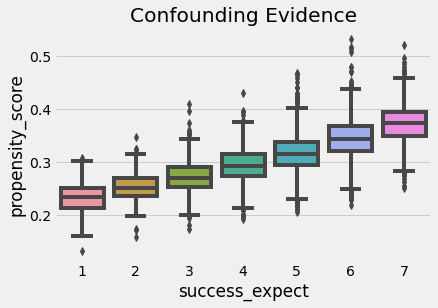

In [10]:
sns.boxplot(x="success_expect", y="propensity_score", data=data_ps)
plt.title("Confounding Evidence");

Nous devons également vérifier qu'il y a un chevauchement entre les populations traitées et non traitées. Pour ce faire, nous pouvons examiner la distribution empirique du score de propension parmi les non-traités et les traités. En regardant l'image ci-dessous, nous pouvons voir que personne n'a un score de propension de zéro et que même dans les régions inférieures du score de propension, nous trouvons à la fois des individus traités et non traités. C'est ce que nous appelons une population traitée et non traitée bien équilibrée.

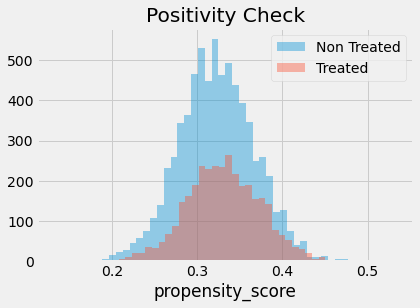

In [11]:
sns.distplot(data_ps.query("intervention==0")["propensity_score"], kde=False, label="Non Treated")
sns.distplot(data_ps.query("intervention==1")["propensity_score"], kde=False, label="Treated")
plt.title("Positivity Check")
plt.legend();

Enfin, nous pouvons utiliser notre estimateur de pondération du score de propension pour estimer l’effet moyen du traitement.

In [12]:
weight = ((data_ps["intervention"]-data_ps["propensity_score"]) /
          (data_ps["propensity_score"]*(1-data_ps["propensity_score"])))

y1 = sum(data_ps.query("intervention==1")["achievement_score"]*weight_t) / len(data)
y0 = sum(data_ps.query("intervention==0")["achievement_score"]*weight_nt) / len(data)

ate = np.mean(weight * data_ps["achievement_score"])

print("Y1:", y1)
print("Y0:", y0)
print("ATE", ate)

Y1: 0.2595823130696891
Y0: -0.1289241686986528
ATE 0.38850648176834174


La pondération par score de propension indique que nous devrions nous attendre à ce que les individus traités soient 0,38 écart-type au-dessus de leurs homologues non traités en termes de réussite. Nous pouvons également constater que si personne n'avait reçu le traitement, nous devrions nous attendre à ce que le niveau général de réussite soit inférieur de 0,12 écart-type à ce qu'il est actuellement. De même, nous devrions nous attendre à ce que le niveau général de réussite soit supérieur de 0,25 écart-type si tout le monde avait suivi le séminaire. Comparons cela à l'estimation de l'effet moyen du traitement (ATE) de 0,47 que nous avons obtenue en comparant simplement les traités et les non-traités. Cela montre que le biais que nous avons est effectivement positif et que le contrôle de X nous donne une estimation plus modeste de l'impact du mindset de croissance.

## Erreur Standard

![img](./data/img/ps/bootstrap.png)

Pour calculer l'erreur standard de l'estimateur IPTW, nous pouvons utiliser la formule de la variance d'une moyenne pondérée.

$$
\sigma^2_w = \dfrac{\sum_{i=1}^{n}w_i(y_i-\hat{\mu})^2}{\sum_{i=1}^{n}w_i}
$$

Cependant, nous ne pouvons utiliser cette formule que si nous avons le véritable score de propension. Si nous utilisons une version estimée de celui-ci, $\hat{P}(x)$, nous devons prendre en compte les erreurs de ce processus d'estimation. La façon la plus simple de le faire est de rééchantillonner (bootstrap) l'ensemble de la procédure. Cela se fait en échantillonnant avec remise à partir des données originales et en calculant l'ATE comme nous l'avons fait précédemment. Ensuite, nous répétons cela de nombreuses fois pour obtenir la distribution de l'estimation de l'ATE.

In [13]:
from joblib import Parallel, delayed # for parallel processing

# define function that computes the IPTW estimator
def run_ps(df, X, T, y):
    # estimate the propensity score
    ps = LogisticRegression(C=1e6, max_iter=1000).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
    
    weight = (df[T]-ps) / (ps*(1-ps)) # define the weights
    return np.mean(weight * df[y]) # compute the ATE

np.random.seed(88)
# run 1000 bootstrap samples
bootstrap_sample = 1000
ates = Parallel(n_jobs=4)(delayed(run_ps)(data_with_categ.sample(frac=1, replace=True), X, T, Y)
                          for _ in range(bootstrap_sample))
ates = np.array(ates)

L'ATE est alors la moyenne des échantillons bootstrap. Pour obtenir les intervalles de confiance, nous pouvons examiner les quantiles de la distribution bootstrap. Pour un intervalle de confiance à 95 %, nous utilisons les percentiles 2,5 et 97,5.

In [14]:
print(f"ATE: {ates.mean()}")
print(f"95% C.I.: {(np.percentile(ates, 2.5), np.percentile(ates, 97.5))}")

ATE: 0.3877446247220722
95% C.I.: (0.3545132414290843, 0.41992560836402076)


Nous pouvons également visualiser à quoi ressemblent les échantillons bootstrap, accompagnés des intervalles de confiance.

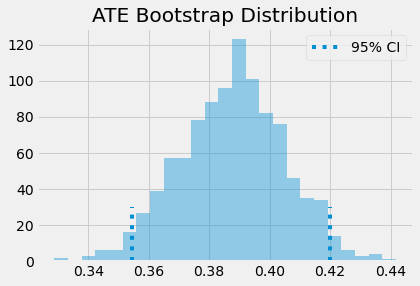

In [15]:
sns.distplot(ates, kde=False)
plt.vlines(np.percentile(ates, 2.5), 0, 30, linestyles="dotted")
plt.vlines(np.percentile(ates, 97.5), 0, 30, linestyles="dotted", label="95% CI")
plt.title("ATE Bootstrap Distribution")
plt.legend();

## Problèmes Courants avec le Score de Propension

En tant que data scientist, je sais qu'il peut être tentant d'utiliser toute la puissance des outils de machine learning pour rendre l'estimation du score de propension aussi précise que possible. Il est facile de se laisser emporter par l'optimisation de l'AUC, la validation croisée et l'ajustement bayésien des hyperparamètres. Maintenant, je ne dis pas que vous ne devriez pas faire cela. En fait, toute la théorie sur le score de propension et le machine learning est très récente, donc il y a beaucoup de choses que nous ne savons pas encore. Mais il est important de comprendre certaines choses d'abord.

La première chose à comprendre est que la qualité prédictive du score de propension ne se traduit pas nécessairement par de bonnes propriétés d'équilibrage. Dans le domaine du machine learning, l'un des aspects les plus difficiles à appréhender lorsqu'on aborde l'inférence causale est de cesser de traiter tout comme un problème de prédiction. En réalité, maximiser le pouvoir prédictif du score de propension peut même nuire à l'objectif de l'inférence causale. **Le score de propension n'a pas besoin de prédire très bien le traitement ; il doit simplement inclure toutes les variables de confusion**. Si nous incluons des variables qui sont très efficaces pour prédire le traitement mais qui n'ont aucun impact sur le résultat, cela augmentera en fait la variance de l'estimateur du score de propension. Cela est similaire au problème que rencontre la régression linéaire lorsqu'on inclut des variables corrélées avec le traitement mais pas avec le résultat.

![img](./data/img/ps/ml-trap.png)

Pour illustrer cela, considérons l'exemple suivant (adapté du livre de Hernán). Vous avez deux écoles, l'une d'entre elles applique le séminaire sur le mindset de croissance à 99 % de ses élèves et l'autre à 1 %. Supposons que les écoles n'ont aucun impact sur l'effet du traitement (sauf par le biais du traitement lui-même), donc il n'est pas nécessaire de contrôler pour cela. Si vous ajoutez la variable « école » au modèle de score de propension, elle va avoir un très haut pouvoir prédictif. Cependant, par hasard, nous pourrions nous retrouver avec un échantillon où tous les élèves de l'école A ont reçu le traitement, ce qui entraînerait un score de propension de 1 pour cette école, menant à une variance infinie. C'est un exemple extrême, mais voyons comment cela fonctionnerait avec des données simulées.

In [16]:
np.random.seed(42)
school_a = pd.DataFrame(dict(T=np.random.binomial(1, .99, 400), school=0, intercept=1))
school_b = pd.DataFrame(dict(T=np.random.binomial(1, .01, 400), school=1, intercept=1))
ex_data = pd.concat([school_a, school_b]).assign(y = lambda d: np.random.normal(1 + 0.1 * d["T"]))
ex_data.head()

,T,school,intercept,y
0,1,0,1,0.309526
1,1,0,1,1.571468
2,1,0,1,2.982024
3,1,0,1,2.445420
4,1,0,1,2.693187


Après avoir simulé ces données, nous exécutons le bootstrap avec l'algorithme du score de propension deux fois. La première fois, en incluant l'école comme variable dans le modèle de score de propension. La deuxième fois, sans inclure l'école dans le modèle.

In [17]:
ate_w_f = np.array([run_ps(ex_data.sample(frac=1, replace=True), ["school"], "T", "y") for _ in range(500)])
ate_wo_f = np.array([run_ps(ex_data.sample(frac=1, replace=True), ["intercept"], "T", "y") for _ in range(500)])

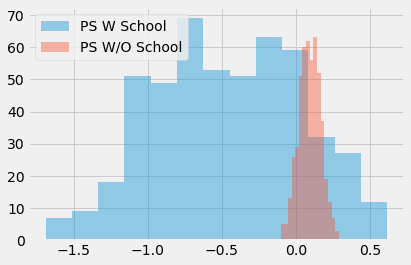

In [18]:
sns.distplot(ate_w_f, kde=False, label="PS W School")
sns.distplot(ate_wo_f, kde=False, label="PS W/O School")
plt.legend();

Comme vous pouvez le voir, l'estimateur du score de propension qui inclut la variable école a une variance énorme, tandis que celui qui ne l'inclut pas est beaucoup plus stable. De plus, puisque l'école n'est pas une variable de confusion, le modèle sans cette variable n'est pas non plus biaisé. Comme je l'ai mentionné, il ne s'agit pas simplement de prédire le traitement. Nous devons en fait construire la prédiction de manière à contrôler les variables de confusion, et non simplement à prédire le traitement.

Cela nous amène à un autre problème souvent rencontré avec les méthodes de score de propension. Dans notre cas de mindset, les données se sont avérées très équilibrées. Mais ce n'est pas toujours le cas. Dans certaines situations, les traités ont une probabilité de traitement beaucoup plus élevée que les non-traités, et la distribution des scores de propension ne se chevauche pas beaucoup.

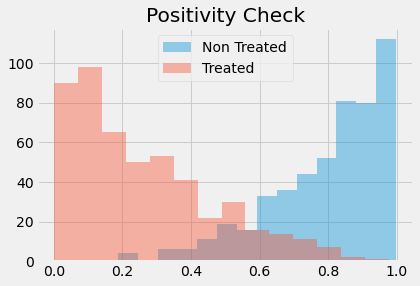

In [19]:
sns.distplot(np.random.beta(4,1,500), kde=False, label="Non Treated")
sns.distplot(np.random.beta(1,3,500), kde=False, label="Treated")
plt.title("Positivity Check")
plt.legend();

Si cela se produit, cela signifie que la positivité n'est pas très forte. Par exemple, si un traité a un score de propension de 0,9 et que le score de propension maximum des non-traités est de 0,7, nous n'aurons aucun non-traité à comparer à l'individu avec un score de propension de 0,9. Ce manque d'équilibre peut générer un biais, car nous devrons extrapoler l'effet du traitement à des régions inconnues. De plus, les entités ayant des scores de propension très élevés ou très faibles ont un poids très élevé, ce qui augmente la variance. En règle générale, vous êtes en difficulté si un poids dépasse 20 (ce qui se produit avec un non-traité ayant un score de propension de 0,95 ou un traité ayant un score de propension de 0,05).

Une alternative consiste à limiter le poids à une taille maximale de 20. Cela réduira la variance, mais cela générera également plus de biais. Pour être honnête, bien que cette pratique soit courante pour réduire la variance, je ne l'apprécie pas vraiment. Vous ne saurez jamais si le biais que vous induisez en limitant le poids est excessif. De plus, si les distributions ne se chevauchent pas, vos données ne sont probablement pas suffisantes pour tirer une conclusion causale de toute façon. Pour approfondir cette intuition, nous pouvons examiner une technique qui combine le score de propension et l'appariement.

## Matching par Score de Propension

Comme je l'ai déjà mentionné, vous n'avez pas besoin de contrôler X lorsque vous avez le score de propension. Il suffit de contrôler ce dernier. Ainsi, vous pouvez considérer le score de propension comme une sorte de réduction dimensionnelle de l'espace des caractéristiques. Il condense toutes les variables de X en une seule dimension d'attribution de traitement. Pour cette raison, nous pouvons traiter le score de propension comme une variable d'entrée pour d'autres modèles. Prenons, par exemple, un modèle de régression.

In [20]:
smf.ols("achievement_score ~ intervention + propensity_score", data=data_ps).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-3.0770,0.065,-47.061,0.000,-3.205,-2.949
intervention,0.3930,0.019,20.974,0.000,0.356,0.430
propensity_score,9.0554,0.200,45.314,0.000,8.664,9.447


Si nous contrôlons le score de propension, nous estimons maintenant un ATE de 0,39, ce qui est inférieur aux 0,47 que nous avions obtenus précédemment avec un modèle de régression sans contrôler le score de propension. Nous pouvons également utiliser l'appariement basé sur le score de propension. Cette fois, au lieu de chercher des correspondances qui sont similaires sur toutes les caractéristiques X, nous pouvons trouver des correspondances qui ont simplement le même score de propension.

C'est une amélioration considérable par rapport à l'estimateur d'appariement, car cela permet de résoudre le problème de la dimensionnalité. De plus, si une caractéristique est peu importante pour l'attribution du traitement, le modèle de score de propension l'apprendra et lui accordera peu d'importance lors de l'ajustement du mécanisme de traitement. En revanche, l'appariement basé sur les caractéristiques tenterait tout de même de trouver des correspondances où les individus sont similaires sur cette caractéristique peu importante.

In [21]:
cm = CausalModel(
    Y=data_ps["achievement_score"].values, 
    D=data_ps["intervention"].values, 
    X=data_ps[["propensity_score"]].values
)

cm.est_via_matching(matches=1, bias_adj=True)

print(cm.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.389      0.025     15.579      0.000      0.340      0.438
           ATC      0.382      0.027     13.921      0.000      0.328      0.435
           ATT      0.405      0.027     15.175      0.000      0.353      0.457



Comme nous pouvons le voir, nous obtenons également un ATE de 0,38, ce qui est plus en ligne avec ce que nous avons observé précédemment avec la pondération par score de propension. L'appariement sur le score de propension nous donne également une intuition sur les dangers d'un faible chevauchement du score de propension entre les traités et les non-traités. Si cela se produit, la différence de score de propension lors de l'appariement sera importante, ce qui entraînera un biais, comme nous l'avons vu dans le chapitre sur l'appariement.

Un dernier point d'attention est que les erreurs standards ci-dessus sont incorrectes, car elles ne tiennent pas compte de l'incertitude dans l'estimation du score de propension. Malheureusement, [le bootstrap ne fonctionne pas avec l'appariement](https://economics.mit.edu/sites/default/files/publications/ON%20THE%20FAILURE%20OF%20THE%20BOOTSTRAP%20FOR.pdf). De plus, la théorie ci-dessus est si récente qu'il n'existe pas encore de mises en œuvre en Python des méthodes de score de propension avec les erreurs standards correctes. Pour cette raison, nous ne voyons pas beaucoup d'appariement par score de propension en Python.

## Idées Clés

Ici, nous avons appris que la probabilité de recevoir le traitement est appelée score de propension et que nous pouvons utiliser celui-ci comme score d'équilibrage. Cela signifie que, si nous disposons du score de propension, nous n'avons pas besoin de contrôler directement les variables de confusion. Il suffit de contrôler le score de propension pour identifier l'effet causal. Nous avons vu comment le score de propension agit comme une réduction dimensionnelle de l'espace des variables de confusion.

Ces propriétés nous ont permis de dériver un estimateur de pondération pour l'inférence causale. De plus, nous avons vu comment le score de propension peut être utilisé avec d'autres méthodes pour contrôler le biais de confusion.

Ensuite, nous avons examiné certains problèmes courants qui peuvent survenir avec le score de propension et avec l'inférence causale en général. Le premier est lorsque nous nous laissons emporter par la tâche d'ajuster le mécanisme de traitement. Nous avons vu que, de manière très contre-intuitive (et donc facile à mal comprendre), augmenter la performance prédictive du traitement **n'améliore pas** nécessairement l'estimation causale, car cela peut augmenter la variance.

Enfin, nous avons abordé certains problèmes d'extrapolation auxquels nous pourrions être confrontés si nous n'arrivons pas à obtenir un bon chevauchement entre les distributions de scores de propension des traités et des non-traités.

## Références

J'aime penser à ce livre entier comme un hommage à Joshua Angrist, Alberto Abadie et Christopher Walters pour leur incroyable cours d'économétrie. La plupart des idées ici sont tirées de leurs cours à l'American Economic Association. Les regarder est ce qui me maintient sain d'esprit pendant cette année difficile de 2020.
* [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
* [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

Je tiens également à référencer les livres incroyables d'Angrist. Ils m'ont montré que l'économétrie, ou 'Metrics' comme ils l'appellent, n'est pas seulement extrêmement utile mais aussi profondément amusante.

* [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com/)
* [Mastering 'Metrics](https://www.masteringmetrics.com/)

Ma dernière référence est le livre de Miguel Hernan et Jamie Robins. Il a été mon compagnon fidèle dans les questions causales les plus épineuses que j'ai dû résoudre.

* [Causal Inference Book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)

Les données utilisées ici proviennent d'une étude de Alpert, William T., Kenneth A. Couch, et Oskar R. Harmon. 2016. ["A Randomized Assessment of Online Learning"](https://www.aeaweb.org/articles?id=10.1257/aer.p20161057). American Economic Review, 106 (5): 378-82.

![img](./data/img/poetry.png)

## Contribuer

*L'Inférence Causale pour les Courageux et les Vrais* est un matériel open-source sur l'inférence causale, la statistique de la science. Son objectif est d'être accessible monétairement et intellectuellement. Il utilise uniquement des logiciels gratuits basés sur Python.
Si vous avez trouvé ce livre précieux et souhaitez le soutenir, veuillez vous rendre sur [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). Si vous n'êtes pas prêt à contribuer financièrement, vous pouvez également aider en corrigeant les fautes de frappe, en suggérant des modifications ou en donnant votre avis sur les passages que vous n'avez pas compris. Rendez-vous sur le repo du livre et [ouvrez une issue](https://github.com/matheusfacure/python-causality-handbook/issues). Enfin, si vous avez aimé ce contenu, veuillez le partager avec d'autres personnes qui pourraient le trouver utile et lui donner une [étoile sur GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).